# Going Bottom-up approach now

In [1]:
%matplotlib inline
from fastai import *

Whatever we did in lesson-2, where we studied SGD, now we're gonna build a neural network for the MNIST dataset (grab it from http://deeplearning.net/data/mnist/mnist.pkl.gz)

In [2]:
man wget

In [3]:
path = Path('data/mnist')

In [4]:
path.mkdir(parents = True, exist_ok = True)

In [5]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -P {path}

--2018-12-06 10:53:39--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  13.6MB/s    in 1.1s    

2018-12-06 10:53:40 (13.6 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [16168813/16168813]



In [6]:
with gzip.open(path/'mnist.pkl.gz', mode = 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = 'latin-1')

In [7]:
f

<gzip on 0x7f1819fac6d8>

In [8]:
x_train.shape

(50000, 784)

In [9]:
y_train.shape

(50000,)

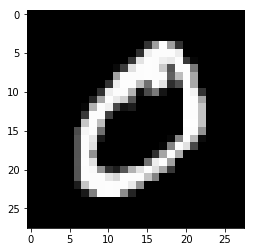

In [11]:
plt.imshow(x_train[1].reshape((28,28)), cmap = 'gray')

In [15]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# Map the normal numpy arrays into tensors by using the above function from pyTorch

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [16]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

Now in Lesson-2, we had hand-coded the SGD functions. We'll take the help of Pytorch now to implement SGD

In [21]:
TensorDataset??

We can make a custom simple dataset using the above pytorch function. Note that TensorDataset takes tensors as input

In [22]:
train_ds = TensorDataset(x_train, y_train)

In [23]:
valid_ds = TensorDataset(x_valid, y_valid)

In [25]:
DataBunch.create??

In [27]:
bs = 64

In [28]:
data = DataBunch.create(train_ds, valid_ds, bs = bs)

In [34]:
x, y = next(iter(data.train_dl))

In [35]:
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

Now we'll create a Logistic regression neural network using the nn module of pytorch

In [36]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias = True) # Applies a linear transformation to the input data
    
    def forward(self, xb) : return self.lin(xb)
        
# Since we're making our own neural network class, we need to call the super's init to build the framework

        

In [38]:
model = Mnist_Logistic().cuda()

In [39]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [40]:
model(x).shape

torch.Size([64, 10])

In [42]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [43]:
lr = 2e-2

In [44]:
loss_fn = nn.CrossEntropyLoss()

In [45]:
def update_params(x, y, lr):
    wd = 1e-5 # Weight decay constant
    y_hat = model(x)
    # Adding L2 regularization (weight decay)
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    loss = loss_fn(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad) # sub_ makes subtraction in-place
            p.grad.zero_()
    return loss.item()

In [46]:
losses = [update_params(x, y, lr) for x, y in data.train_dl]

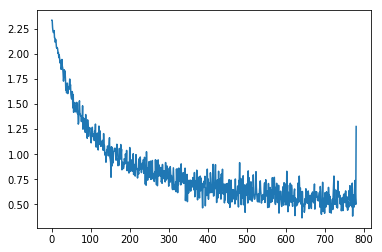

In [47]:
plt.plot(losses)